# 계절학기 - AI 8팀
| RAG 챗봇
## 목차
***
### 1. Solar mini API 통신
### 2. CSV 파싱
### 3. 문서 임베딩
#### 3-1. 문서 가공/필터링
#### 3-2. Chroma 벡터 DB 저장
## 4. LLM 쿼리
### 4-1. Query 입력
### 4-2. Retriever 병렬 처리
### 4-3. Context 병합
### 4-4. 질의 답변 생성
***

### 필요한 라이브러리 다운로드

In [ ]:
!pip install -qU openai langchain langchain-upstage langchain-chroma getpass4

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.0/755.0 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

https://console.upstage.ai/api-keys

In [43]:
# @title set API key
import os
import getpass
import warnings

warnings.filterwarnings("ignore")

# Get the Upstage API key using getpass
os.environ["UPSTAGE_API_KEY"] = getpass.getpass("Enter your Upstage API key: ")

print("API key has been set successfully.")

Enter your Upstage API key: ··········
API key has been set successfully.


# 문서 임베딩
| vector DB 생성 이후 생략

## CSV 파싱

In [97]:
# @title patients.csv (환자 기본 정보)

from langchain.schema import Document
import pandas as pd
from typing import List

# patients.csv 읽기 (환자 기본 정보)
df = pd.read_csv("patients.csv")

# csv에서 사례화
def row_to_text(row) -> str:
    text = (
        f"환자 ID: {row['Id'][0:8]}\n"
        f"기본 정보: {row['BIRTHDATE']}에 태어났고, 성별은 {row['GENDER']}, 인종은 {row['RACE']}, 민족성은 {row['ETHNICITY']}입니다."
        # 나이 추가할 것
    )
    return text

texts = df.apply(row_to_text, axis=1).tolist()

# 문서 리스트 준비
patients_docs = []
for _, row in df.iterrows():
    text = row_to_text(row)
    patients_docs.append(Document(page_content=text, metadata={"patient_id": row["Id"][0:8], "table": "patients"}))

print("총 문서 수:", len(patients_docs))
print("예시 문서:\n", patients_docs[1].page_content)

총 문서 수: 1182
예시 문서:
 환자 ID: a0c8480c
기본 정보: 2024-01-09에 태어났고, 성별은 F, 인종은 white, 민족성은 nonhispanic입니다.


In [32]:
# @title conditions.csv (진단 질병)

import pandas as pd
from langchain.schema import Document
import numpy as np

# conditions.csv 읽기
df = pd.read_csv("conditions.csv")

# disorder만 필터링
df = df[df["DESCRIPTION"].str.contains(r"\(disorder\)", na=False)].copy()

# ✅ (disorder) 제거
df["DESCRIPTION"] = df["DESCRIPTION"].str.replace(r"\s*\(disorder\)", "", regex=True)

# ✅ STOP이 null이면 "현재"로 대체
df["STOP"] = df["STOP"].fillna("현재")

# PATIENT_ID 기준으로 그룹화
grouped = df.groupby("PATIENT")

# 환자별 사례화 함수
def patient_conditions_to_text(patient_id, group_df):
    conditions_text = ""
    for _, row in group_df.iterrows():
        stop_date = row["STOP"]
        conditions_text += (
            f"{row['START']}부터 {stop_date}까지 "
            f"{row['DESCRIPTION']} 진단 받았습니다. "
        )
    text = f"환자 ID: {patient_id[0:8]}\n해당 환자는 다음과 같은 질병을 진단 받았습니다. {conditions_text}"
    return text

# 문서 리스트 준비
conditions_docs = []
for patient_id, group_df in grouped:
    text = patient_conditions_to_text(patient_id, group_df)
    conditions_docs.append(Document(page_content=text, metadata={"patient_id": patient_id[0:8], "table": "conditions"}))

print("총 문서 수:", len(conditions_docs))
print("예시 문서:\n", conditions_docs[0].page_content)

총 문서 수: 1171
예시 문서:
 환자 ID: 0057c08f
해당 환자는 다음과 같은 질병을 진단 받았습니다. 2012-03-22부터 현재까지 Anemia 진단 받았습니다. 2015-11-12부터 2015-11-27까지 Gingivitis 진단 받았습니다. 2015-11-13부터 2015-12-08까지 Viral sinusitis 진단 받았습니다. 2018-11-01부터 2018-11-24까지 Viral sinusitis 진단 받았습니다. 2024-01-19부터 2024-02-02까지 Gingivitis 진단 받았습니다. 2024-02-02부터 2024-02-02까지 Gingival disease 진단 받았습니다. 


In [28]:
import pandas as pd

# CSV 파일 읽기
df = pd.read_csv('/content/filter_obervation.csv')

# DESCRIPTION별 개수 세기
description_counts = df['DESCRIPTION'].value_counts()

# 8000번 이상 등장한 DESCRIPTION만 필터링
descriptions_over_8000 = description_counts[description_counts > 8000].index.tolist()

# 결과 출력
print(f"8000개 넘는 DESCRIPTION 수: {len(descriptions_over_8000)}개")
print("DESCRIPTION 리스트:")
for desc in descriptions_over_8000:
    print(f"{desc} ({description_counts[desc]}개)")


8000개 넘는 DESCRIPTION 수: 42개
DESCRIPTION 리스트:
Diastolic Blood Pressure (17939개)
Systolic Blood Pressure (17939개)
Body Weight (16838개)
Heart rate (16300개)
Respiratory rate (16300개)
Body mass index (BMI) [Ratio] (14999개)
Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum or Plasma by Creatinine-based formula (MDRD) (13682개)
Chloride [Moles/volume] in Blood (10844개)
Urea nitrogen [Mass/volume] in Blood (10844개)
Creatinine [Mass/volume] in Blood (10844개)
Sodium [Moles/volume] in Blood (10844개)
Potassium [Moles/volume] in Blood (10844개)
Calcium [Mass/volume] in Blood (10844개)
Glucose [Mass/volume] in Blood (10844개)
Carbon dioxide  total [Moles/volume] in Blood (10844개)
Weight difference [Mass difference] --pre dialysis - post dialysis (10515개)
Hemoglobin A1c/Hemoglobin.total in Blood (10099개)
Leukocyte esterase [Presence] in Urine by Test strip (8893개)
Nitrite [Presence] in Urine by Test strip (8893개)
pH of Urine by Test strip (8893개)
Specific gravity of Urine by Test

In [137]:
# @title observations.csv (신체/바이탈 정보)

import pandas as pd
from langchain.schema import Document

# CSV 읽기
df = pd.read_csv("test_observation_over_8000.csv")

# descriptions 리스트 예시 (코드 상단에 정의되어 있다고 가정)
descriptions = descriptions_over_8000

# ✅ Respiratory rate 제외
descriptions = [desc for desc in descriptions if desc != "Respiratory rate"]

# 행 단위 text 생성 함수
def row_to_text(row) -> str:
    text = f"{row['DATE'][:10]}에 기록: "
    for description in descriptions:
        matching_columns = [col for col in row.index if description == col.split(' [')[0]]
        if matching_columns:
            full_col_name = matching_columns[0]
            value = row[full_col_name]
            if pd.notna(value):
                if description == "Body Weight":
                    value_str = f"{value:.1f}"  # 소수 유지
                else:
                    value_str = f"{int(round(value))}"  # 정수 변환
                text += f"{description}: {value_str} "
    return text

# ✅ patient_id 기준 그룹화
grouped = df.groupby("PATIENT")

# 환자별 Document 생성
observation_docs = []

for patient_id, group_df in grouped:
    text_lines = []
    for _, row in group_df.iterrows():
        line = row_to_text(row)
        text_lines.append(line)

    combined_text = f"환자 ID: {patient_id[:8]}\n환자는 다음과 같은 바이탈/검사 데이터를 기록했습니다:\n" + "\n".join(text_lines)

    # Document 생성
    observation_docs.append(Document(page_content=combined_text, metadata={"patient_id": patient_id[:8], "table": "observations"}))

In [138]:
print("총 환자 수 (문서 수):", len(observation_docs))
print("예시 문서:\n", observation_docs[0].page_content)

총 환자 수 (문서 수): 1122
예시 문서:
 환자 ID: 0057c08f
환자는 다음과 같은 바이탈/검사 데이터를 기록했습니다:
2015-11-12에 기록: Diastolic Blood Pressure: 82 Systolic Blood Pressure: 107 Body Weight: 91.7 Heart rate: 63 Hemoglobin A1c/Hemoglobin.total in Blood: 6 
2018-03-29에 기록: Diastolic Blood Pressure: 75 Systolic Blood Pressure: 106 Body Weight: 97.3 Heart rate: 92 Hemoglobin A1c/Hemoglobin.total in Blood: 6 
2021-04-01에 기록: Diastolic Blood Pressure: 81 Systolic Blood Pressure: 96 Body Weight: 92.4 Heart rate: 69 Hemoglobin A1c/Hemoglobin.total in Blood: 6 
2024-01-18에 기록: Diastolic Blood Pressure: 76 Systolic Blood Pressure: 107 Body Weight: 99.1 Heart rate: 97 Hemoglobin A1c/Hemoglobin.total in Blood: 6 


In [90]:
# @title medications.csv (투약 정보)

# medications.csv 읽기 (약물 복용 기록)
import pandas as pd
from langchain.schema import Document

df = pd.read_csv("medications.csv")
df["START"] = pd.to_datetime(df["START"])
df["STOP"] = pd.to_datetime(df["STOP"], errors="coerce")

grouped = df.groupby("PATIENT")
medication_docs = []

for patient_id, group in grouped:
    med_grouped = group.groupby("DESCRIPTION")
    text_lines = []

    for description, med_subgroup in med_grouped:
        earliest = med_subgroup["START"].min()
        latest = med_subgroup["STOP"].max() if med_subgroup["STOP"].notnull().any() else None
        total_dispenses = med_subgroup["DISPENSES"].sum()

        start_str = earliest.strftime("%Y-%m")
        if latest is None:
            period_str = f"{start_str} ~ "
        else:
            stop_str = latest.strftime("%Y-%m")
            period_str = start_str if start_str == stop_str else f"{start_str} ~ {stop_str}"

        text_lines.append(f"- {description}: {period_str}, 총 {total_dispenses}회")

    combined_text = f"환자 ID: {patient_id[:8]}\n환자는 다음 약물을 복용했습니다:\n" + "\n".join(text_lines)
    medication_docs.append(Document(page_content=combined_text, metadata={"patient_id": patient_id[:8], "table": "medications"}))

print("환자 수 (문서 수):", len(medication_docs))
print("예시 문서:\n", medication_docs[0].page_content)


환자 수 (문서 수): 1158
예시 문서:
 환자 ID: 0063c9a6
환자는 다음 약물을 복용했습니다:
- 1 ML heparin sodium  porcine 5000 UNT/ML Injection: 2008-05, 총 1회
- 10 ML Furosemide 10 MG/ML Injection: 2010-04, 총 10회
- 100 ML Propofol 10 MG/ML Injection: 2008-05, 총 1회
- 2 ML Ondansetron 2 MG/ML Injection: 2008-05, 총 1회
- 24 HR metoprolol succinate 100 MG Extended Release Oral Tablet: 2008-05 ~ , 총 24회
- 25 ML protamine sulfate (USP) 10 MG/ML Injection: 2008-05, 총 1회
- 5 ML SUFentanil 0.05 MG/ML Injection: 2008-05, 총 1회
- Clopidogrel 75 MG Oral Tablet: 2008-05 ~ , 총 24회
- Furosemide 40 MG Oral Tablet: 2009-10 ~ , 총 6회
- Ibuprofen 200 MG Oral Tablet: 2008-11 ~ 2008-12, 총 1회
- Midazolam 1 MG/ML Injectable Solution: 2008-05, 총 1회
- Naproxen sodium 220 MG Oral Tablet: 2001-01 ~ 2001-02, 총 1회
- Nitroglycerin 0.4 MG/ACTUAT Mucosal Spray: 2008-05 ~ , 총 24회
- Penicillin V Potassium 500 MG Oral Tablet: 2004-06, 총 1회
- Rocuronium bromide 10 MG/ML Injectable Solution: 2008-05, 총 1회
- Simvastatin 10 MG Oral Tablet: 2003-04 ~ 2009-0

In [109]:
# @title allergies.csv (알러지 반응 기록)

import pandas as pd
from langchain.schema import Document
import re

# allergies.csv 읽기
df = pd.read_csv("allergies.csv")

# 환자별 그룹화
grouped = df.groupby("PATIENT")

# 문서 리스트
allergy_docs = []

for patient_id, group in grouped:
    text_lines = []
    for _, row in group.iterrows():
        # 괄호와 안의 내용 제거
        description_clean = re.sub(r"\s*\(.*?\)", "", row['DESCRIPTION']).strip()

        line = f"{description_clean}"
        text_lines.append(line)

    # 전체 문서 구성
    combined_text = f"환자 ID: {patient_id[:8]}\n환자는 다음과 같은 알레르기 반응을 보였습니다:\n" + "\n".join(text_lines)

    # Document 생성
    allergy_docs.append(Document(page_content=combined_text, metadata={"patient_id": patient_id[:8], "table": "allergies"}))

print("환자 수 (문서 수):", len(allergy_docs))
print("예시 문서:\n", allergy_docs[20].page_content)

환자 수 (문서 수): 202
예시 문서:
 환자 ID: 18ebb069
환자는 다음과 같은 알레르기 반응을 보였습니다:
Allergic disposition
Aspirin


In [140]:
# @title 사례 통합

import re
from datetime import datetime

def create_summarized_case(pid, docs):
    # 기본 정보
    age_str = "알 수 없음"
    gender_str = "알 수 없음"
    weight_str = ""
    race_str = ""
    vitals_str = ""
    allergies_str = ""
    reason_str = ""
    med_name = ""
    med_count = ""
    med_unit = ""

    # docs 분류
    for doc in docs:
        table = doc.metadata.get("table")

        # 기본 정보 및 observation
        if table == "patients":
            content = doc.page_content
            # 예: 1970-01-01에서 나이 계산
            birth_match = re.search(r'기본 정보: (\d{4})', content)
            if birth_match:
                birth_year = int(birth_match.group(1))
                age = datetime.now().year - birth_year
                age_str = f"{age}"

            gender_match = re.search(r'성별은 (\w)', content)
            if gender_match:
                gender_raw = gender_match.group(1)
                gender_str = "남성" if gender_raw == "M" else "여성"

            race_match = re.search(r'인종은 (\w+)', content)
            if race_match:
                race_str = race_match.group(1)

        if table == "observations":
            bw_match = re.search(r'Body Weight: (\d+\.\d+)', doc.page_content)
            if bw_match:
                weight_str = bw_match.group(1)

            # 날짜별 블록 분리
            vitals_blocks = re.findall(r'(\d{4}-\d{2}-\d{2}에 기록:.*?)(?=\d{4}-\d{2}-\d{2}에 기록:|$)', doc.page_content, re.DOTALL)

            vitals_list = []

            for block in vitals_blocks:
                # 날짜 추출
                date_match = re.search(r'(\d{4}-\d{2}-\d{2})에 기록:', block)
                date_str = date_match.group(1) if date_match else "날짜 불명"

                # vitals 데이터 추출
                block_vitals = re.findall(r'(\w+ Blood Pressure: \d+|Heart rate: \d+|Body Weight: \d+\.\d+)', block)

                if block_vitals:
                    # 한 날짜 블록으로 묶기
                    vitals_combined = ", ".join(block_vitals)
                    vitals_list.append(f"{date_str}: {vitals_combined}")

            # 모든 블록을 쉼표로 이어 붙임
            vitals_str = ", ".join(vitals_list)
            if vitals_str:
                vitals_str += "의 신체/바이탈 정보"

        if table == "allergies":
            # 줄바꿈을 쉼표로 바꿔 연결
            allergies_clean = doc.page_content.replace("\n", ", ")

            # "환자는 다음과 같은 알레르기 반응을 보였습니다:" 이후만 남기기
            content_split = allergies_clean.split("환자는 다음과 같은 알레르기 반응을 보였습니다:", 1)
            if len(content_split) > 1:
                allergies_only = content_split[1].strip(", ").strip()
                if allergies_only:  # 알러지 정보가 비어있지 않은 경우만
                    allergies_str = allergies_only + "의 알러지 정보"
            else:
                allergies_str = ""

        if table == "medications":
            # 약물명 파싱
            med_name_match = re.search(r'- (.+?):', doc.page_content)
            if med_name_match:
                med_name_full = med_name_match.group(1)

                # 용량 패턴 찾기
                unit_match = re.search(r'(\d+\s*(?:MG|ML))', med_name_full, re.IGNORECASE)
                if unit_match:
                    med_unit = unit_match.group(1)
                    # 약물명에서 용량 제거
                    med_name = med_name_full.replace(med_unit, "").strip()
                else:
                    med_name = med_name_full  # 용량이 없으면 원문 그대로

            # 횟수 파싱
            dispenses_match = re.search(r'총 (\d+)회', doc.page_content)
            if dispenses_match:
                med_count = dispenses_match.group(1)

    # 문장 구성
    final_text = (
        f"만 {age_str}세 {weight_str}kg의 {gender_str} 환자는 "
        f"{vitals_str}, {allergies_str}를 갖고 있고, "
        f"{reason_str}라는 이유로 {med_name}을 {med_count}회 {med_unit}씩 복용했습니다."
    )

    return Document(page_content=final_text, metadata={"patient_id": pid, "table": "merged_summary"})

# ✅ 최종 문서 생성
merged_docs = []
for pid, docs in patient_groups.items():
    merged_doc = create_summarized_case(pid, docs)
    merged_docs.append(merged_doc)

print("생성된 문서 수:", len(merged_docs))
print("예시 문서:\n", merged_docs[1].page_content)


생성된 문서 수: 1182
예시 문서:
 만 1세 3.3kg 여성 환자는 2024-01-09: Diastolic Blood Pressure: 94, Systolic Blood Pressure: 133, Body Weight: 3.3, Heart rate: 72, 2024-02-13: Diastolic Blood Pressure: 88, Systolic Blood Pressure: 142, Body Weight: 4.0, Heart rate: 98, 2024-04-16: Diastolic Blood Pressure: 94, Systolic Blood Pressure: 137, Body Weight: 5.2, Heart rate: 69, 2024-06-18: Diastolic Blood Pressure: 92, Systolic Blood Pressure: 130, Body Weight: 6.2, Heart rate: 92, 2024-06-25: Diastolic Blood Pressure: 89, Systolic Blood Pressure: 130, Body Weight: 6.2, Heart rate: 61, 2024-09-17: Diastolic Blood Pressure: 89, Systolic Blood Pressure: 129, Body Weight: 7.5, Heart rate: 82, 2024-12-17: Diastolic Blood Pressure: 88, Systolic Blood Pressure: 122, Body Weight: 8.5, Heart rate: 63, 2025-03-18: Diastolic Blood Pressure: 86, Systolic Blood Pressure: 126, Body Weight: 9.3, Heart rate: 98, 2025-06-17: Diastolic Blood Pressure: 98, Systolic Blood Pressure: 123, Body Weight: 9.9, Heart rate: 92의 신체/바이

In [144]:
import numpy as np

# 각 문서의 문자열 길이 측정
lengths = [len(doc.page_content) for doc in merged_docs]

# 통계 계산
avg_len = np.mean(lengths)
median_len = np.median(lengths)
min_len = np.min(lengths)
max_len = np.max(lengths)

# 출력
print("총 문서 수:", len(lengths))
print(f"평균 문자열 길이: {avg_len:.2f}")
print(f"중앙값 문자열 길이: {median_len}")
print(f"최소 문자열 길이: {min_len}")
print(f"최대 문자열 길이: {max_len}")


총 문서 수: 1182
평균 문자열 길이: 1600.57
중앙값 문자열 길이: 1237.5
최소 문자열 길이: 75
최대 문자열 길이: 30543


## Chunking 작업

In [145]:
# Splitter 설정
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=100,
)

# 실제 split
splits = text_splitter.split_documents(merged_docs)

# 결과 출력
print("Splits:", len(splits))


Splits: 1523


### Plot 시각화

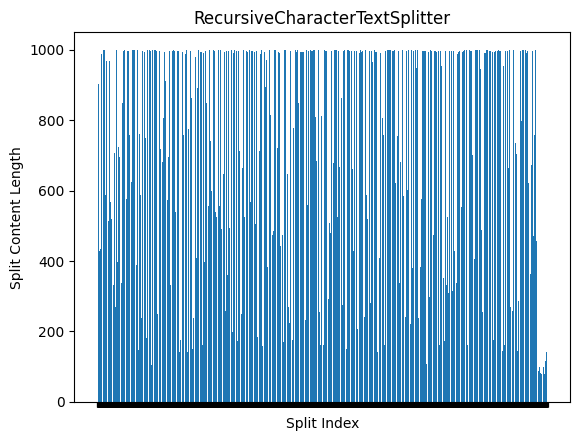

In [124]:
# 시각화
import matplotlib.pyplot as plt

split_lengths = [len(split.page_content) for split in splits]

plt.bar(range(len(split_lengths)), split_lengths)
plt.title("RecursiveCharacterTextSplitter")
plt.xlabel("Split Index")
plt.ylabel("Split Content Length")
plt.xticks(range(len(split_lengths)), [])
plt.show()

## Vector DB 저장

In [46]:
from langchain_chroma import Chroma
from langchain_upstage import UpstageEmbeddings
from langchain.docstore.document import Document

In [54]:
import time

batch_size = 100  # 한 번에 처리할 문서 수

for i in range(0, len(splits), batch_size):
    batch = splits[i:i+batch_size]
    try:
        vectorstore = Chroma.from_documents(
            documents=batch,
            embedding=embeddings,
            persist_directory="./chroma_db"
        )
    except Exception as e:
        print(f"Batch {i//batch_size + 1} 처리 중 오류 발생:", e)
        time.sleep(60)  # Rate limit 회피를 위해 잠시 대기


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture

Batch 4 처리 중 오류 발생: Error code: 429 - {'error': {'message': "You've reached your API request limit. Please wait and try again later. If your use case requires a higher rate limit, you can request an increase at https://support.upstage.ai. Including your intended use case and expected volume will help us process your request faster", 'type': 'too_many_requests', 'param': '', 'code': 'too_many_requests'}}


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture

Batch 8 처리 중 오류 발생: Error code: 429 - {'error': {'message': "You've reached your API request limit. Please wait and try again later. If your use case requires a higher rate limit, you can request an increase at https://support.upstage.ai. Including your intended use case and expected volume will help us process your request faster", 'type': 'too_many_requests', 'param': '', 'code': 'too_many_requests'}}


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture

Batch 12 처리 중 오류 발생: Error code: 429 - {'error': {'message': "You've reached your API request limit. Please wait and try again later. If your use case requires a higher rate limit, you can request an increase at https://support.upstage.ai. Including your intended use case and expected volume will help us process your request faster", 'type': 'too_many_requests', 'param': '', 'code': 'too_many_requests'}}


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


Batch 15 처리 중 오류 발생: Error code: 429 - {'error': {'message': "You've reached your API request limit. Please wait and try again later. If your use case requires a higher rate limit, you can request an increase at https://support.upstage.ai. Including your intended use case and expected volume will help us process your request faster", 'type': 'too_many_requests', 'param': '', 'code': 'too_many_requests'}}


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


Batch 17 처리 중 오류 발생: Error code: 429 - {'error': {'message': "You've reached your API request limit. Please wait and try again later. If your use case requires a higher rate limit, you can request an increase at https://support.upstage.ai. Including your intended use case and expected volume will help us process your request faster", 'type': 'too_many_requests', 'param': '', 'code': 'too_many_requests'}}


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


Batch 20 처리 중 오류 발생: Error code: 429 - {'error': {'message': "You've reached your API request limit. Please wait and try again later. If your use case requires a higher rate limit, you can request an increase at https://support.upstage.ai. Including your intended use case and expected volume will help us process your request faster", 'type': 'too_many_requests', 'param': '', 'code': 'too_many_requests'}}


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


Batch 23 처리 중 오류 발생: Error code: 429 - {'error': {'message': "You've reached your API request limit. Please wait and try again later. If your use case requires a higher rate limit, you can request an increase at https://support.upstage.ai. Including your intended use case and expected volume will help us process your request faster", 'type': 'too_many_requests', 'param': '', 'code': 'too_many_requests'}}


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [55]:
# @title zip으로 압축/저장
!zip -r /content/chroma_db.zip /content/chroma_db

  adding: content/chroma_db/ (stored 0%)
  adding: content/chroma_db/chroma.sqlite3 (deflated 65%)
  adding: content/chroma_db/0b73a7ae-b747-4a33-bb10-4a03fb090c54/ (stored 0%)
  adding: content/chroma_db/0b73a7ae-b747-4a33-bb10-4a03fb090c54/length.bin (deflated 100%)
  adding: content/chroma_db/0b73a7ae-b747-4a33-bb10-4a03fb090c54/index_metadata.pickle (deflated 50%)
  adding: content/chroma_db/0b73a7ae-b747-4a33-bb10-4a03fb090c54/data_level0.bin (deflated 94%)
  adding: content/chroma_db/0b73a7ae-b747-4a33-bb10-4a03fb090c54/link_lists.bin (deflated 87%)
  adding: content/chroma_db/0b73a7ae-b747-4a33-bb10-4a03fb090c54/header.bin (deflated 57%)


# Vector DB 로드

In [ ]:
# @title 압축 풀기
!unzip /content/chroma_db.zip -d /content/chroma_db

Archive:  /content/chroma_medications.zip
   creating: /content/chroma_medications_db/df8167d2-d336-451e-a06a-10d3ccffcc6d/
  inflating: /content/chroma_medications_db/chroma.sqlite3  
  inflating: /content/chroma_medications_db/df8167d2-d336-451e-a06a-10d3ccffcc6d/length.bin  
  inflating: /content/chroma_medications_db/df8167d2-d336-451e-a06a-10d3ccffcc6d/index_metadata.pickle  
  inflating: /content/chroma_medications_db/df8167d2-d336-451e-a06a-10d3ccffcc6d/data_level0.bin  
  inflating: /content/chroma_medications_db/df8167d2-d336-451e-a06a-10d3ccffcc6d/link_lists.bin  
  inflating: /content/chroma_medications_db/df8167d2-d336-451e-a06a-10d3ccffcc6d/header.bin  
Archive:  /content/chroma_alloergies.zip
   creating: /content/chroma_alloergies_db/cf098646-18d3-4908-aa14-f1971b317a14/
  inflating: /content/chroma_alloergies_db/chroma.sqlite3  
  inflating: /content/chroma_alloergies_db/cf098646-18d3-4908-aa14-f1971b317a14/length.bin  
  inflating: /content/chroma_alloergies_db/cf09864

In [ ]:
from langchain_chroma import Chroma
from langchain_upstage import UpstageEmbeddings
from langchain.docstore.document import Document

# 1️⃣ Embeddings 객체 선언
embeddings = UpstageEmbeddings(model="embedding-query")

vectorstore = Chroma(
    persist_directory="/content/chroma_db",
    embedding_function=embeddings
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture

# LLM 생성

In [133]:
# ✅ Dense Retriever 생성
# retriever = vectorstore.as_retriever(
#     search_type="mmr",
#     search_kwargs={"k": 5},
# )

## similarity
# retriever = vectorstore.as_retriever(
#     search_type="similarity_score_threshold",
#     search_kwargs={"k": 5, "score_threshold": 0.1},
# )

# print(retriever)

results = vectorstore.similarity_search_with_score(query, k=5)

for doc, score in results:
    print(f"Score: {score}")
    print(f"Content: {doc.page_content[:100]}")
    print("-" * 30)

# ✅ 사용자의 한국어 질문 예시
query = "환자가 심장이 아프다고 하는데, 어떤 약물을 투약해야 돼."

# ✅ 검색된 문서 가져오기
docs = retriever.invoke(query)

# ✅ 한국어 system 프롬프트 정의
from langchain_upstage import ChatUpstage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = ChatUpstage()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            당신은 환자 정보 기반으로 약물 투여를 제안하는 한국어 의료 AI 어시스턴트입니다.

            아래 CONTEXT는 하나의 통합된 환자 사례 정보로 제공됩니다. 이 정보를 참고하여 전문 의료진에게 전달할 수 있도록 간결하고 핵심적으로 요약해 주세요.

            - CONTEXT에 포함되지 않은 내용은 절대 작성하지 마세요. 모르면 "모른다"고 명확히 답변하세요.
            - 의료진이 빠르게 참고할 수 있도록 문단 형태로 정리하며, 불필요한 수식어는 생략하고 중요한 핵심 정보만 포함하세요.
            - 투약 권장 시, 환자의 기본 정보, 진단 질병, 바이탈/검사 결과, 기존 투약 기록, 알러지 정보를 함께 고려해 주세요.
            - 환자 ID는 CONTEXT 상단에 이미 명시되어 있으므로 다시 반복하지 마세요.

            간결하고 전문적인 톤으로 작성하며, 필요 시 투약 제안 및 주의사항도 포함하세요.
            ---
            CONTEXT:
            {context}
            """,
        ),
        ("human", "{input}"),
    ]
)

# ✅ LLM chain 구성
chain = prompt | llm | StrOutputParser()

# ✅ 최종 chain 호출
response = chain.invoke({"context": docs, "input": query})

print("\n💬 AI의 답변:")
print(response)


Score: 1.1497232913970947
Content: 투약 정보: 환자는 다음 약물을 복용했습니다:
0.25 ML Leuprolide Acetate 30 MG/ML Prefilled Syringe을 2018-08-29부터 2018-0
------------------------------
Score: 1.1588361263275146
Content: 투약 정보: 환자는 다음 약물을 복용했습니다:
Levothyroxine Sodium 0.075 MG Oral Tablet을 2011-12-26부터 현재까지 총 6회 복용했습니다.

------------------------------
Score: 1.1630909442901611
Content: 투약 정보: 환자는 다음 약물을 복용했습니다:
0.4 ML Enoxaparin sodium 100 MG/ML Prefilled Syringe을 2020-10-25부터 2020-10
------------------------------
Score: 1.1659116744995117
Content: 투약 정보: 환자는 다음 약물을 복용했습니다:
24 HR metoprolol succinate 100 MG Extended Release Oral Tablet을 1994-09-21
------------------------------
Score: 1.1663563251495361
Content: 투약 정보: 환자는 다음 약물을 복용했습니다:
1 ML heparin sodium  porcine 5000 UNT/ML Injection을 2019-02-04부터 2019-02-0
------------------------------



💬 AI의 답변:
제공된 CONTEXT에는 환자의 기본 정보, 진단 질병, 바이탈/검사 결과, 기존 투약 기록, 알러지 정보와 같은 중요한 정보가 포함되어 있지 않습니다. 따라서 환자의 상태를 정확히 파악하고 약물을 제안하기 위해서는 추가적인 정보가 필요합니다. 심장의 통증은 다양한 원인에 의해 발생할 수 있으며, 이에 따라 다른 약물이 처방될 수 있습니다. 예를 들어, 협심증이나 심근경색의 경우 니트로글리세린이나 아스피린과 같은 약물이 필요할 수 있으며, 부정맥의 경우 항부정맥제가 필요할 수 있습니다. 따라서 정확한 진단과 의료진의 평가를 바탕으로 약물 투여가 결정되어야 합니다.


# v2 결론

## 동작
- 5개의 retriever 별로 5개씩 정보 가져옴
- context는 5 * 5개의 정보를 통합함
- LLM은 context를 토대로 Query에 적절한 답변

## 성능
- 소요 시간: 8 ~ 10초
- 답변 정확도(임의 판단)
  - 정보 조합해서 잘 설명하는 것처럼 보임
  - 실제 환자 ID를 입력했을 때, 일부 누락됨 (데이터가 있음에도)
